# Case Santander Customer Satisfaction

Este projeto utiliza como base o dataset da competição Santander Customer Satisfaction, disponibilizada no Kaggle em 2016. O objetivo original da competição é identificar clientes insatisfeitos a partir de centenas de variáveis anonimizadas, permitindo que o banco possa agir de forma antecipada para reduzir churn. A métrica oficial de avaliação é a área sob a curva ROC (ROC_AUC), calculada a partir da probabilidade prevista para a variável TARGET, que indica se o cliente está satisfeito ou não.

A competição pode ser encontrada em:
https://www.kaggle.com/competitions/santander-customer-satisfaction

Objetivos:
O objetivo deste projeto é tratar o problema como uma tarefa de classificação binária, buscando identificar clientes insatisfeitos a partir das variáveis disponíveis. A partir das previsões do modelo, é construído um cenário hipotético de negócio, no qual se simula um custo associado a ações de retenção e à perda de clientes, com o intuito de maximizar o lucro esperado por cliente.
A partir desse ponto, desdobramentos e análises adicionais são possíveis, conforme a evolução do modelo e das hipóteses consideradas.

# Instalações & Importações

In [1]:
# Instalação de Bibliotecas (Já estão presentes no requirements.txt)
# !pip install numpy
# !pip install seaborn
# !pip install scikit-learn
# !pip install scipy
# !pip install factor_analyzer
# !pip install matplotlib
# !pip install catboost
# !pip install graphviz
# !pip install plotly
# !pip install six
# !pip install shap-selection
# !pip install shap-selection

In [2]:
# Bibliotecas Basicas
import numpy as np 
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt 
import sklearn

## Validação Cruzada e Pipeline
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif

## Métricas de Validação
from sklearn.metrics import average_precision_score, roc_auc_score 
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay

## Pré-processamento
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Cluster Hierárquico
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

# Modelos
import xgboost 
from xgboost import XGBClassifier
from  sklearn.linear_model import LogisticRegression
from  sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Funções

## Funções de Relatório e Pré-Processamento

In [3]:
def calcula_prevalencia(y_actual):
    '''
    Calcula e exibe a prevalência da classe positiva em um conjunto de rótulos reais.
    '''
    print(f'Prevalência da classe não nula (1): {sum(y_actual) * 100/ len(y_actual):.3f}%')


def calcula_valores_validos(df):
    '''
    Calcula e exibe a porcentagem de valores nulos ou faltantes em cada coluna do DataFrame apenas se existirem.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado. 
    '''
    valores_exibidos = 0
    for col in df.columns:
        soma_nulos = sum(df[col].isnull() | df[col].isna())
        if soma_nulos > 0 :
            print(f'Valores Nulos em {col}: {soma_nulos * 100/ len(df[col]):.3f}%')
            valores_exibidos += 1
    if valores_exibidos == 0:
        print('Nenhum valor nulo ou faltante encontrado no DataFrame.')


def verifica_balanceamento(df, coluna_alvo):
    '''
    Verifica o balanceamento das classes em uma coluna alvo de um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    coluna_alvo (str): O nome da coluna alvo que contém as classes.
    '''
    contagem_classes = df[coluna_alvo].value_counts()
    proporcao_classes = df[coluna_alvo].value_counts(normalize=True) * 100
    balanceamento = pd.DataFrame({'Contagem': contagem_classes, 'Proporção (%)': np.round(proporcao_classes, 2)})
    print(balanceamento)


def verifica_coluna_constante(df):
    '''
    Verifica se há colunas constantes (com o mesmo valor em todas as linhas) em um DataFrame.
    Parâmetros:
    df (pandas.DataFrame): O DataFrame a ser verificado.
    '''
    colunas_constantes = [col for col in df.columns if df[col].nunique() == 1]
    if colunas_constantes:
        print(f'Colunas constantes encontradas: {colunas_constantes}')
    else:
        print('Nenhuma coluna constante encontrada.')


def relatorio(df: pd.DataFrame) -> None:
    """Gera um breve relatório exploratório do DataFrame"""


    print("=" * 70)
    print(f"Número de Colunas: {df.shape[1]:,}")
    print(f"Número de Linhas: {df.shape[0]:,}")
    print("=" * 70)

    # Linhas duplicadas (ignorando ID)
    dup_mask = df.drop(columns=['ID','TARGET'], errors='ignore').duplicated(keep='first')
    print(f"Número de Linhas Duplicadas: {dup_mask.sum():,}")

    # Colunas constantes
    const_cols = [
        c for c in df.columns
        if c != 'ID' and df[c].nunique(dropna=False) == 1
    ]
    print(f"Número de Colunas Constantes: {len(const_cols):,}")

    # Colunas idênticas (Aprofundar o Conceitual)
    col_hashes = df.apply(lambda col: hash(tuple(col)), axis=0)
    num_identicas = col_hashes.duplicated().sum()
    print(f"Número de Colunas Idênticas: {num_identicas:,}")

    print("=" * 70)

    # Valores nulos
    nulls = df.isnull().sum()
    nulls = nulls[nulls > 0].sort_values(ascending=False)
    print(f"Colunas com Valores Nulos: {len(nulls):,}")

    print("=" * 70)

    # Distribuição da variável TARGET
    if 'TARGET' in df.columns:
        target_0 = (df['TARGET'] == 0).sum()
        target_1 = (df['TARGET'] == 1).sum()
        total = len(df)

        print(f"TARGET = 0 (Insatisfeitos): {target_0:,} ({target_0 / total:.1%})")
        print(f"TARGET = 1 (Satisfeitos): {target_1:,} ({target_1 / total:.1%})")
        print(f"Total de clientes: {total:,}")
    else:
        print("Coluna TARGET não encontrada.")

    print("=" * 70)


## Funções de Cross-Validation Personalizadas

In [4]:
def threshold_otimizado_f1(y_true, y_prob, n_thresholds=100):
    """
    Encontra o threshold que maximiza o F1-score.
    """
    thresholds = np.linspace(0.01, 0.99, n_thresholds)
    best_f1 = -1
    best_threshold = 0.5

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        f1 = f1_score(y_true, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1


def validacao_cruzada_f1(
    modelo, 
    X, 
    y,
    metric,
    oversampler=None, 
    n_splits=5,
    shuffle=False,
    random_state=None
):
    """
    Validação cruzada com threshold otimizado para F1-score.
    """
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    scores = []
    thresholds_otimos = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

        # Clonar modelo 
        modelo_fold = clone(modelo)

        X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        # Oversampling SOMENTE no treino
        if oversampler is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        # Treinamento
        modelo_fold.fit(X_train, y_train)

        # Probabilidade da classe positiva
        y_prob = modelo_fold.predict_proba(X_test)[:, 1]

        # Threshold ótimo + F1
        best_threshold, best_f1 = threshold_otimizado_f1(y_test, y_prob)

        scores.append(best_f1)
        thresholds_otimos.append(best_threshold)

        print(
            f"Fold {fold}: "
            f"F1 = {best_f1:.4f} | "
            f"Threshold ótimo = {best_threshold:.2f}"
        )

    print("\nResumo da Validação Cruzada")
    print(f"F1 médio: {np.mean(scores):.4f}")
    print(f"Desvio padrão F1: {np.std(scores):.4f}")
    print(f"Threshold médio: {np.mean(thresholds_otimos):.2f}")

    return {
        "f1_scores": scores,
        "thresholds": thresholds_otimos
    }


def validacao_cruzada_prauc(
    modelo, 
    X, 
    y,
    oversampler=None, 
    n_splits=5,
    shuffle=False,
    random_state=None
):
    """
    Validação cruzada usando PR-AUC (Average Precision).
    Avalia ranking, não threshold.
    """

    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    pr_auc_scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):

        # Clonar modelo
        modelo_fold = clone(modelo)

        X_train = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        X_test  = X.iloc[test_idx]  if hasattr(X, "iloc") else X[test_idx]
        y_train = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        y_test  = y.iloc[test_idx]  if hasattr(y, "iloc") else y[test_idx]

        # Oversampling SOMENTE no treino
        if oversampler is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        # Treinamento
        modelo_fold.fit(X_train, y_train)

        # Score contínuo da classe positiva
        y_prob = modelo_fold.predict_proba(X_test)[:, 1]

        # PR-AUC (Average Precision)
        pr_auc = average_precision_score(y_test, y_prob)
        pr_auc_scores.append(pr_auc)

        print(
            f"Fold {fold}: "
            f"PR-AUC = {pr_auc:.4f}"
        )

    print("\nResumo da Validação Cruzada")
    print(f"PR-AUC médio: {np.mean(pr_auc_scores):.4f}")
    print(f"Desvio padrão PR-AUC: {np.std(pr_auc_scores):.4f}")

    return {
        "pr_auc_scores": pr_auc_scores
    }



## Funções de Pipeline

In [5]:
class PipeSteps(BaseEstimator, TransformerMixin):
    def __init__(self, columns = []):
        self.columns = columns

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X = X.copy()
        return X

class SelecionaColunas(PipeSteps):
    def transform(self, X):
        X = X.copy()
        return X[self.columns]

class PadronizaDados(PipeSteps):
    def fit(self, X, y = None ):
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y =None):
        X = X.copy()
        X[self.columns] = self.scaler.transform(X[self.columns])
        return X

# Importação de Arquivos

In [6]:
df_train = pd.read_csv("data/processed/train.csv")
df_test = pd.read_csv("data/processed/test.csv")

# Análise Exploratória

In [7]:
df_train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [8]:
df_test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


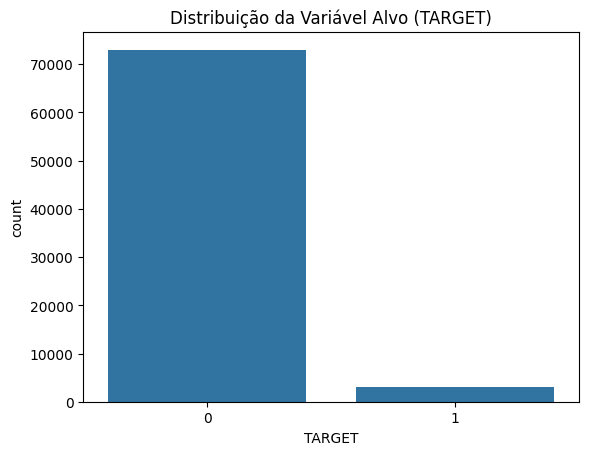

In [10]:
sns.countplot(x='TARGET', data=df_train)
plt.title('Distribuição da Variável Alvo (TARGET)')
plt.show()

In [11]:
verifica_balanceamento(df_train,'TARGET')
calcula_valores_validos(df_train)
verifica_coluna_constante(df_train)

        Contagem  Proporção (%)
TARGET                         
0          73012          96.04
1           3008           3.96
Nenhum valor nulo ou faltante encontrado no DataFrame.
Colunas constantes encontradas: ['ind_var2_0', 'ind_var2', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var28', 'saldo_var27', 'saldo_var41', 'saldo_var46', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_reemb_var13_hace3', 'imp_reemb_var33_hace3', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_reemb_var13_hace3', 'num_reemb_var33_hace3', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo_var2_ult1', 'saldo_medio_var13_medio_hace3']


In [12]:
relatorio(df_train)

Número de Colunas: 371
Número de Linhas: 76,020
Número de Linhas Duplicadas: 4,940
Número de Colunas Constantes: 34
Número de Colunas Idênticas: 62
Colunas com Valores Nulos: 0
TARGET = 0 (Insatisfeitos): 73,012 (96.0%)
TARGET = 1 (Satisfeitos): 3,008 (4.0%)
Total de clientes: 76,020


In [13]:
# Colunas Categóricas
cat_cols = df_train.select_dtypes(include=['object', 'category']).columns

print('Colunas categóricas:', list(cat_cols))
print('Qtd:', len(cat_cols))

# Possíveis colunas categóricas numéricas ou com Baixo Número valores únicos
candidate_cat = [
    col for col in df_train.select_dtypes(include=['int', 'int64', 'float']).columns
    if df_train[col].nunique() <= 10
]

# Serão usadas para análises futuras
print('Possíveis categóricas numéricas:', len(candidate_cat))

Colunas categóricas: []
Qtd: 0
Possíveis categóricas numéricas: 239


# Separação em Treino e Validação

In [14]:
# Lista dos atributos que serão utilizados como entrada (Diferentes da classe alvo, ID e não constantes)
atributos = [x for x in df_train.columns if 
             (df_train[f'{x}'].nunique() > 1 
              and x not in ('Class', 'TARGET', 'ID'))]

In [15]:
X = df_train[atributos]
y = df_train['TARGET']
X_treino, X_teste, y_treino, y_teste = train_test_split(
                                                    X, 
                                                    y,
                                                    stratify=y, 
                                                    test_size = 0.30, 
                                                    random_state = 42)

In [16]:
calcula_prevalencia(y_treino)

Prevalência da classe não nula (1): 3.958%


In [17]:
calcula_prevalencia(y_teste)

Prevalência da classe não nula (1): 3.955%


# Modelos Base

In [18]:
'ID' in atributos

False

In [19]:
pipe_prepropcessamento = Pipeline([
    ('standard_scaling', PadronizaDados(atributos))
])

# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        ('preprocessing', pipe_prepropcessamento),
        ('classifier', modelo)
    ])

    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X,
        y,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)


Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.7913
Desvio ROC_AUC: 0.0097
PR_AUC médio : 0.1420
Desvio PR_AUC: 0.0098
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.8188
Desvio ROC_AUC: 0.0099
PR_AUC médio : 0.1713
Desvio PR_AUC: 0.0158
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7582
Desvio ROC_AUC: 0.0124
PR_AUC médio : 0.1116
Desvio PR_AUC: 0.0050
--------------------------------------------------


# Seleção de Features

## Análise de Corelação entre as Variáveis

In [20]:
# Cálculo da matriz de correlação
corr_matrix = X.corr()

# Mantém apenas correlações fortes (maior que 0.5 ou menor que -0.5) 
# excluindo a diagonal principal
strong_corr = corr_matrix.where(
    (np.abs(corr_matrix) > 0.5) & (np.abs(corr_matrix) < 1.0)
)

# Remoção de linhas e colunas que são completamente NaN
strong_corr_clean = (
    strong_corr
    .dropna(how='all', axis=1)
    .dropna(how='all', axis=0)
)

# Máscara para ocultar a parte superior da matriz de correlação
mask_upper = np.triu(
    np.ones_like(strong_corr_clean, dtype=bool),
    k=1
)

# Aplicação da máscara
strong_corr_final = strong_corr_clean.mask(mask_upper)

# Conversão para DataFrame longo
corr_df = (
    strong_corr_final
    .stack()
    .dropna()
    .reset_index()
    .rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'correlation'
    })
)

# Filtragem para correlações absolutas maiores que 0.9
corr_df_90 = (
    strong_corr_final[strong_corr_final.abs() > 0.9]
    .stack()
    .dropna()
    .reset_index()
    .rename(columns={
        'level_0': 'feature_1',
        'level_1': 'feature_2',
        0: 'correlation'
    })
)

print(
    'N de correlações |corr| > 0.99 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.99])
)

print(
    'N de correlações |corr| > 0.9 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.9])
)

print(
    'N de correlações |corr| > 0.8 =',
    len(corr_df[np.abs(corr_df['correlation']) > 0.8])
)

N de correlações |corr| > 0.99 = 86
N de correlações |corr| > 0.9 = 284
N de correlações |corr| > 0.8 = 483


In [21]:
contador = 0
sus_col = []
for col in candidate_cat:
    if col in corr_df_90['feature_1'].values or col in corr_df_90['feature_2'].values:
        contador += 1
        sus_col.append(col)

print('Colunas categóricas suspeitas que possuem alguma correlação > 0.9:', len(sus_col))
print('') # Melhora a legibilidade

# Filtra apenas as correlações absolutas maiores que 0.9 entre colunas categóricas suspeitas
corr_df_90_sus_cat = corr_df_90[(corr_df_90['feature_1'].isin(sus_col)) 
                                | (corr_df_90['feature_2'].isin(sus_col))]


contador = 0
sus_col_inter = []
for col in candidate_cat:
    if col in corr_df_90['feature_1'].values or col in corr_df_90['feature_2'].values:
        contador += 1
        sus_col_inter.append(col)

print('Colunas categóricas suspeitas que possuem alguma correlação > 0.9 entre si:', len(sus_col_inter))

Colunas categóricas suspeitas que possuem alguma correlação > 0.9: 140

Colunas categóricas suspeitas que possuem alguma correlação > 0.9 entre si: 140


Muitas Colunas categóricas suspeitas e que possuem alguma forte correlçao com outra (n=140) sendo que todas elas possuem essa forte correlação entre si

### Agrupamento das Features via Sperman

In [22]:
# Módulo das Correlações
corr = X.corr(method='spearman').abs()

# Transformar em Distância
dist = 1 - corr

dist_condensed = squareform(dist.values)

Z = linkage(dist_condensed, method='average')

# Corte do dendrograma para formar clusters
cutoff = 0.1  
clusters = fcluster(Z, t=cutoff, criterion='distance')

# Dicionário com os Cluster
cluster_map = (
    pd.DataFrame({
        'feature': corr.index,
        'cluster': clusters
    })
    .sort_values(by='cluster')
    .reset_index(drop=True)
)

# Contagem de variáveis por cluster
counts = cluster_map['cluster'].value_counts()

# Clusters com mais de uma variável
clusters_gt1 = counts[counts > 1].sort_values(ascending=False)

# Exibição dos resultados
print('Total de clusters formados com > 1 variáveis:', len(clusters_gt1))
# print('Lista')
# for cluster, count in clusters_gt1.items():
#     print(f'Cluster = {cluster} | variáveis (n) = {count}')

# Selecionar uma variável representativa de cada cluster
selected = []
for cluster_id in np.unique(clusters):
    
    features = cluster_map.query(
        "cluster == @cluster_id"
    )["feature"]

    X_cluster = X_treino[features]

    mi = mutual_info_classif(
        X_cluster,
        y_treino,
        discrete_features="auto",
        random_state=42
    )

    mi_series = pd.Series(mi, index=features)
    best = mi_series.idxmax()

    selected.append(best)


Total de clusters formados com > 1 variáveis: 75


In [23]:
import math

def print_cols(items, n_cols=3):
    rows = math.ceil(len(items) / n_cols)
    cols = [items[i*rows:(i+1)*rows] for i in range(n_cols)]

    for row in zip(*[c + ['']*(rows-len(c)) for c in cols]):
        print('  '.join(f'{x:<40}' for x in row if x))

print('Listagem\n')

for cluster, count in clusters_gt1.items():
    if count > 3:
        vars_ = cluster_map.loc[
            cluster_map["cluster"] == cluster, "feature"
        ].tolist()

        print(f'Cluster = {cluster} | variáveis (n) = {count}')
        print_cols(vars_, n_cols=3)  
        print('-' * 80)


Listagem

Cluster = 68 | variáveis (n) = 12
ind_var26_0                               num_var25_0                               saldo_var26                             
ind_var25_cte                             ind_var25_0                               saldo_var25                             
ind_var26_cte                             ind_var25                                 num_var25                               
num_var26_0                               ind_var26                                 num_var26                               
--------------------------------------------------------------------------------
Cluster = 31 | variáveis (n) = 9
num_var33                                 saldo_medio_var33_ult1                    num_var33_0                             
num_meses_var33_ult3                      ind_var33                                 ind_var33_0                             
saldo_medio_var33_ult3                    saldo_var33                               saldo_me

In [24]:
'ID' in selected

False

In [25]:
# Segurança para remover 'ID' se estiver na lista selected
if 'ID' in selected:
    selected.remove('ID')

# Modelos c/ Seleção de Features

In [26]:
# Criação do pipeline de pré-processamento com as colunas selecionadas
pipe_prepropcessamento = Pipeline([('feature_selection', SelecionaColunas(selected)),
                                       ('standard_scaling', PadronizaDados(selected))])
# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
}


for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        ('preprocessamento', pipe_prepropcessamento),
        ('classifier', modelo)
    ])

    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X,
        y,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)


Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.7918
Desvio ROC_AUC: 0.0092
PR_AUC médio : 0.1429
Desvio PR_AUC: 0.0110
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.8197
Desvio ROC_AUC: 0.0093
PR_AUC médio : 0.1683
Desvio PR_AUC: 0.0158
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7578
Desvio ROC_AUC: 0.0129
PR_AUC médio : 0.1118
Desvio PR_AUC: 0.0049
--------------------------------------------------


# PCA

In [27]:
'ID' in X_treino

False

In [28]:
scaler = StandardScaler()

X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled  = scaler.transform(X_teste)

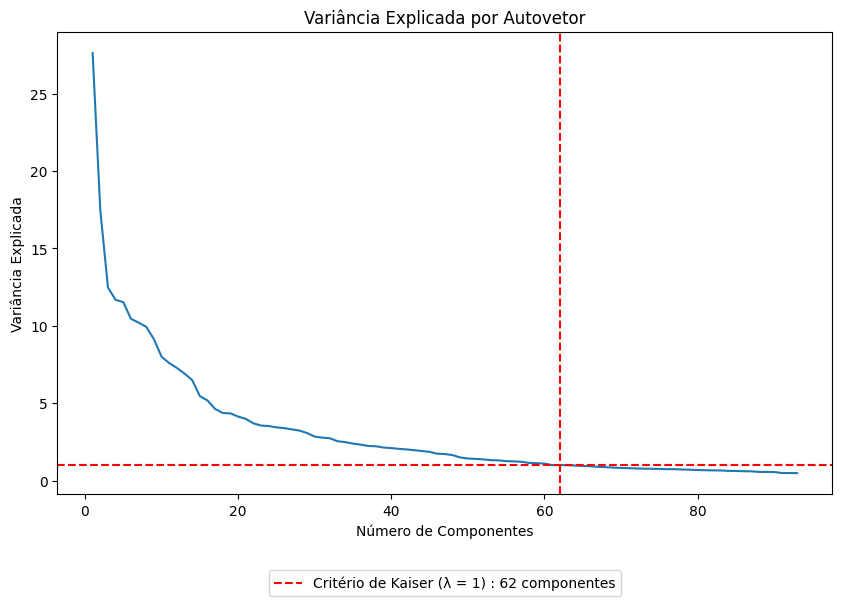

Número de componentes pelo critério de Kaiser: 62


In [29]:
pca = PCA()
X_train_pca = pca.fit_transform(X_treino_scaled)

# Variância Acumlada
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

# Análise Eigenvalues (Critério de Kaiser e Análise de Cotovelo)
eigenvalues = pca.explained_variance_

eigenvalues_kaiser = eigenvalues[eigenvalues > 1]
n_componentes_kaiser = len(eigenvalues_kaiser)

# Plotar até o dobro do número de componentes indicado pelo critério de Kaiser
n_componentes_kaiser_plot = int(n_componentes_kaiser * 1.5)

plt.figure(figsize=(10, 6))
sns.lineplot(
    x=range(1, n_componentes_kaiser_plot + 1),
    y=eigenvalues[0:n_componentes_kaiser_plot])

plt.axvline(
    x=n_componentes_kaiser,
    color='r',
    linestyle='--',
    label=f"Critério de Kaiser (λ = 1) : {n_componentes_kaiser} componentes"
)

plt.axhline(
    y=1,
    color="red",
    linestyle="--"
)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=True
)
plt.title("Variância Explicada por Autovetor")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada")
plt.show()

print(f"Número de componentes pelo critério de Kaiser: {n_componentes_kaiser}")

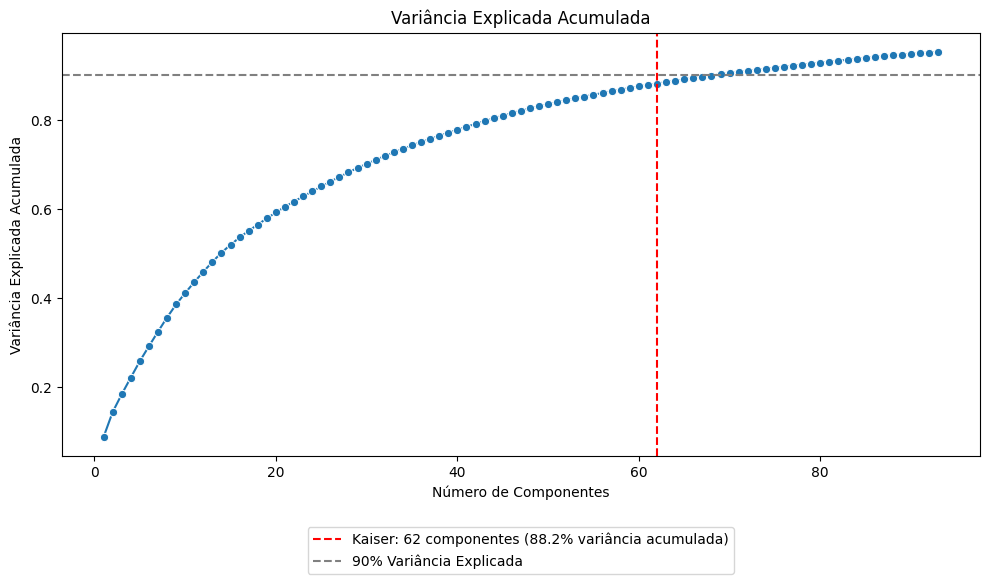

In [30]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    x=range(1, n_componentes_kaiser_plot + 1),
    y=cum_var_exp[:n_componentes_kaiser_plot],
    marker='o'
)

plt.axvline(
    x=n_componentes_kaiser,
    color='r',
    linestyle='--',
    label=(
        f"Kaiser: {n_componentes_kaiser} componentes "
        f"({cum_var_exp[n_componentes_kaiser - 1]:.1%} variância acumulada)"
    )
)

# Linha de referência (ex: 90%)
plt.axhline(
    y=0.9,
    color='gray',
    linestyle='--',
    label='90% Variância Explicada'
)

plt.title("Variância Explicada Acumulada")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")

plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=True
)

plt.tight_layout()
plt.show()

Como parece não haver um "cotovelo" bem definido, vamos usar o critério de kaiser matendo aproxidamente 87,2% da variância acumulada com 62 PC´s

# Modelos com PCA

In [31]:

# Criação dos modelos
lr = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'
)

xgb = XGBClassifier(
    eval_metric='aucpr',
    objective='binary:logistic',
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

modelos = {
    'Logistic Regression': lr,
    'XGBoost': xgb,
    'Random Forest': rf
}

pipelines = {}
score_modelos = {}

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision'
}

for nome_modelo, modelo in modelos.items():

    pipelines[nome_modelo] = Pipeline([
        ('classifier', modelo)
    ])

    print(f'Pipeline para {nome_modelo} criada com sucesso.\n')
    print(f'Validação Cruzada para {nome_modelo}:')

    scores = cross_validate(
        pipelines[nome_modelo],
        X_train_pca,
        y_treino,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    score_modelos[nome_modelo] = scores

    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")

    print('-' * 50)

Pipeline para Logistic Regression criada com sucesso.

Validação Cruzada para Logistic Regression:
ROC_AUC médio: 0.7897
Desvio ROC_AUC: 0.0114
PR_AUC médio : 0.1411
Desvio PR_AUC: 0.0081
--------------------------------------------------
Pipeline para XGBoost criada com sucesso.

Validação Cruzada para XGBoost:
ROC_AUC médio: 0.7594
Desvio ROC_AUC: 0.0128
PR_AUC médio : 0.1360
Desvio PR_AUC: 0.0144
--------------------------------------------------
Pipeline para Random Forest criada com sucesso.

Validação Cruzada para Random Forest:
ROC_AUC médio: 0.7197
Desvio ROC_AUC: 0.0185
PR_AUC médio : 0.0992
Desvio PR_AUC: 0.0086
--------------------------------------------------


# Resultados da Validação Cruzada — Comparação de Modelos

## Baseline

| Modelo              | ROC_AUC (média ± desvio) | PR_AUC (média ± desvio) |
|---------------------|--------------------------|--------------------------|
| Logistic Regression | 0.7913 ± 0.0097          | 0.1420 ± 0.0098          |
| XGBoost             | 0.8188 ± 0.0099          | 0.1713 ± 0.0158          |
| Random Forest       | 0.7582 ± 0.0124          | 0.1116 ± 0.0050          |


## Seleção de Features (Agrupamento)

| Modelo              | ROC_AUC (média ± desvio) | PR_AUC (média ± desvio) |
|---------------------|--------------------------|--------------------------|
| Logistic Regression | 0.7918 ± 0.0092          | 0.1429 ± 0.0110          |
| XGBoost             | 0.8197 ± 0.0093          | 0.1683 ± 0.0158          |
| Random Forest       | 0.7578 ± 0.0129          | 0.1118 ± 0.0049          |

## PCA

| Modelo              | ROC_AUC (média ± desvio) | PR_AUC (média ± desvio) |
|---------------------|--------------------------|--------------------------|
| Logistic Regression | 0.7897 ± 0.0114          | 0.1411 ± 0.0081          |
| XGBoost             | 0.7594 ± 0.0128          | 0.1360 ± 0.0144          |
| Random Forest       | 0.7197 ± 0.0185          | 0.0992 ± 0.0086          |

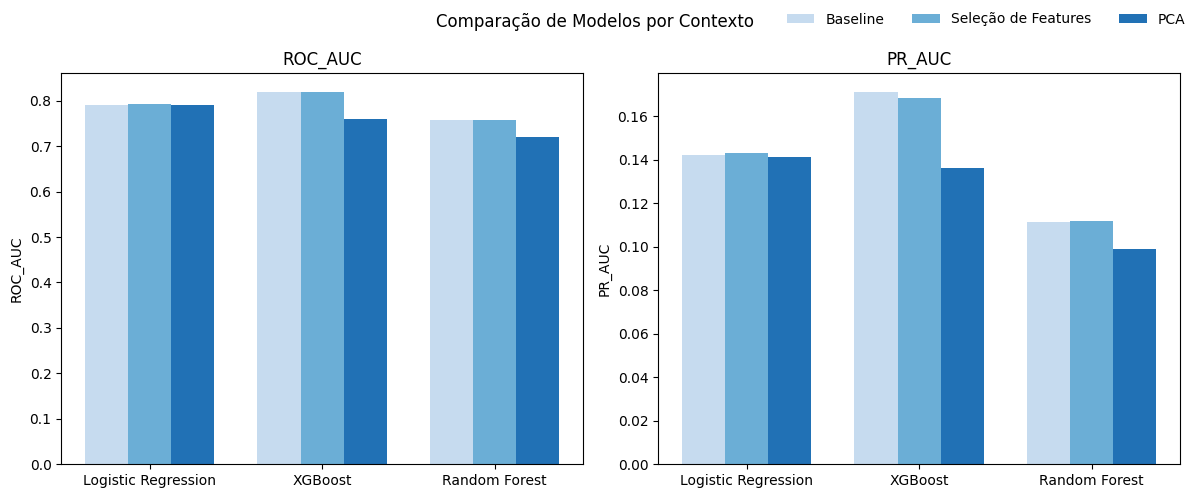

In [32]:
# Dados / Configurações Bases
modelos = ["Logistic Regression", "XGBoost", "Random Forest"]

roc_baseline = [0.7913, 0.8188, 0.7582]
roc_sel = [0.7918, 0.8197, 0.7578]
roc_pca = [0.7897, 0.7594, 0.7197]

pr_baseline = [0.1420, 0.1713, 0.1116]
pr_sel = [0.1429, 0.1683, 0.1118]
pr_pca = [0.1411, 0.1360, 0.0992]

x = np.arange(len(modelos))
width = 0.25

# figura com dois subplots
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharex=True)

# ROC_AUC 
## Colunas
axes[0].bar(x - width, roc_baseline, width, label="Baseline", color="#c6dbef")
axes[0].bar(x,           roc_sel,      width, label="Seleção de Features", color="#6baed6")
axes[0].bar(x + width, roc_pca,     width, label="PCA", color="#2171b5")

## Labels e Títulos
axes[0].set_ylabel("ROC_AUC")
axes[0].set_title("ROC_AUC")
axes[0].set_xticks(x)
axes[0].set_xticklabels(modelos)

# PR_AUC 
## Colunas
axes[1].bar(x - width, pr_baseline, width, label="Baseline", color="#c6dbef")
axes[1].bar(x,           pr_sel,      width, label="Seleção de Features", color="#6baed6")
axes[1].bar(x + width, pr_pca,     width, label="PCA", color="#2171b5")

## Labels e Títulos
axes[1].set_ylabel("PR_AUC")
axes[1].set_title("PR_AUC")
axes[1].set_xticks(x)
axes[1].set_xticklabels(modelos)

# Legendas
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    ncol=3,
    frameon=False
)

fig.suptitle("Comparação de Modelos por Contexto", fontsize=12)
plt.tight_layout()
plt.show()


# Conclusão sobre a seleção de Modelo

Com base nos resultados obtidos nos experimentos de validação cruzada, o modelo a ser utilizado no restante do projeto será o *XGBoost*. Esse Modelo apresentou os melhores valores de *PR_AUC* e *ROC_AUC* em todos os experimentos, com exceção do cenário em que o PCA foi utilizado como etapa de pré-processamento. A queda de performance observada nesse caso pode estar relacionada ao fato de o XGBoost, por utilizar árvores de decisão combinadas por gradient boosting, apresentar melhor desempenho em cenários nos quais existe maior distinção entre as variáveis e maior significado semântico nos atributos originais. Ressalta-se, contudo, que essa hipótese ainda deve ser explorada de forma mais aprofundada.

A partir desse ponto, serão exploradas técnicas adicionais de pré-processo e tunning de hiperparâmetros com o objetivo de atingir o melhor desempenho possível do XGBoost na tarefa de classificação binária. O foco será maximizar a identificação da classe de clientes em churn, de modo a dar base ao planejamento de ações direcionadas a esses clientes, visando o estabelecimento de um cenário de maior ganho financeiro e manutenção da base de clientes.

# Evolução do Modelo Base

In [33]:
# Pré-processamento
pipe_prepropcessamento = Pipeline([
    ('standard_scaling', PadronizaDados(atributos))
])

# Pipeline completo
pipeline_xgb_base = Pipeline([
    ('preprocessing', pipe_prepropcessamento),
    ('XGBoost', XGBClassifier(
                        eval_metric='aucpr',
                        objective='binary:logistic',
                        random_state=42
    ))
])

# Treino do modelo
pipeline_xgb_base.fit(X_treino, y_treino)

# Predição de probabilidades da classe positiva
y_pred = pipeline_xgb_base.predict_proba(X_teste)[:, 1]

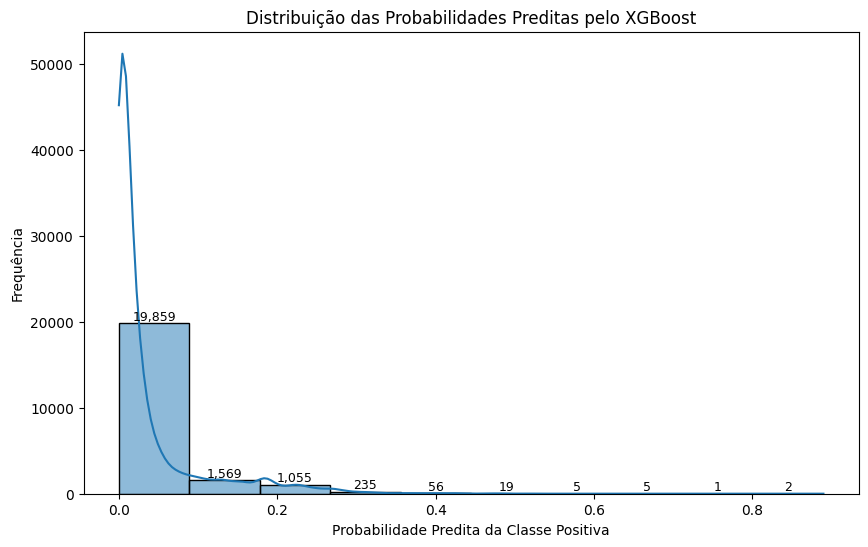

In [34]:
# Plot da distribuição das probabilidades preditas
plt.figure(figsize=(10, 6))
ax = sns.histplot(y_pred, bins=10, kde=True)
plt.title('Distribuição das Probabilidades Preditas pelo XGBoost')
plt.xlabel('Probabilidade Predita da Classe Positiva')
plt.ylabel('Frequência')

# Anotação dos valores em cada barra
for p in ax.patches:
    altura = int(p.get_height())
    if altura > 0:
        ax.annotate(
            f'{altura:,}',
            (p.get_x() + p.get_width() / 2, p.get_height()),
            ha='center',
            va='bottom',
            fontsize=9
        )

plt.show()

In [35]:
# Valores reais da variável alvo no conjunto de teste
y_teste.value_counts()

TARGET
0    21904
1      902
Name: count, dtype: int64

In [36]:
# Importancias
modelo = pipeline_xgb_base['XGBoost']
importancias_ganho = modelo.get_booster().get_score(importance_type='gain') # Aumento médio da performance (mais informativo).
importancias_peso = modelo.get_booster().get_score(importance_type='weight') # Número de vezes que a feature foi usada em divisões.
importancias_cobertura = modelo.get_booster().get_score(importance_type='cover') # Cobertura média (número de observações afetadas).

# DataFrame com diversas métricas de importância
importancias = pd.concat([
    pd.Series(importancias_ganho, name='Ganho'),
    pd.Series(importancias_peso, name='Peso'),
    pd.Series(importancias_cobertura, name='Cobertura')
], axis=1).fillna(0)

print("="*60) 
print("Número de atributos de entradas no modelo",len(atributos))
print("Número de atributos usados pelo modelo",len(importancias))
dif = len(atributos) - len(importancias)
print("="*60)
if dif != 0:
    print("Diferença:", dif)
    print("O Algomodelo não usou todas as features disponíveis.")
print("="*60) 

Número de atributos de entradas no modelo 335
Número de atributos usados pelo modelo 127
Diferença: 208
O Algomodelo não usou todas as features disponíveis.


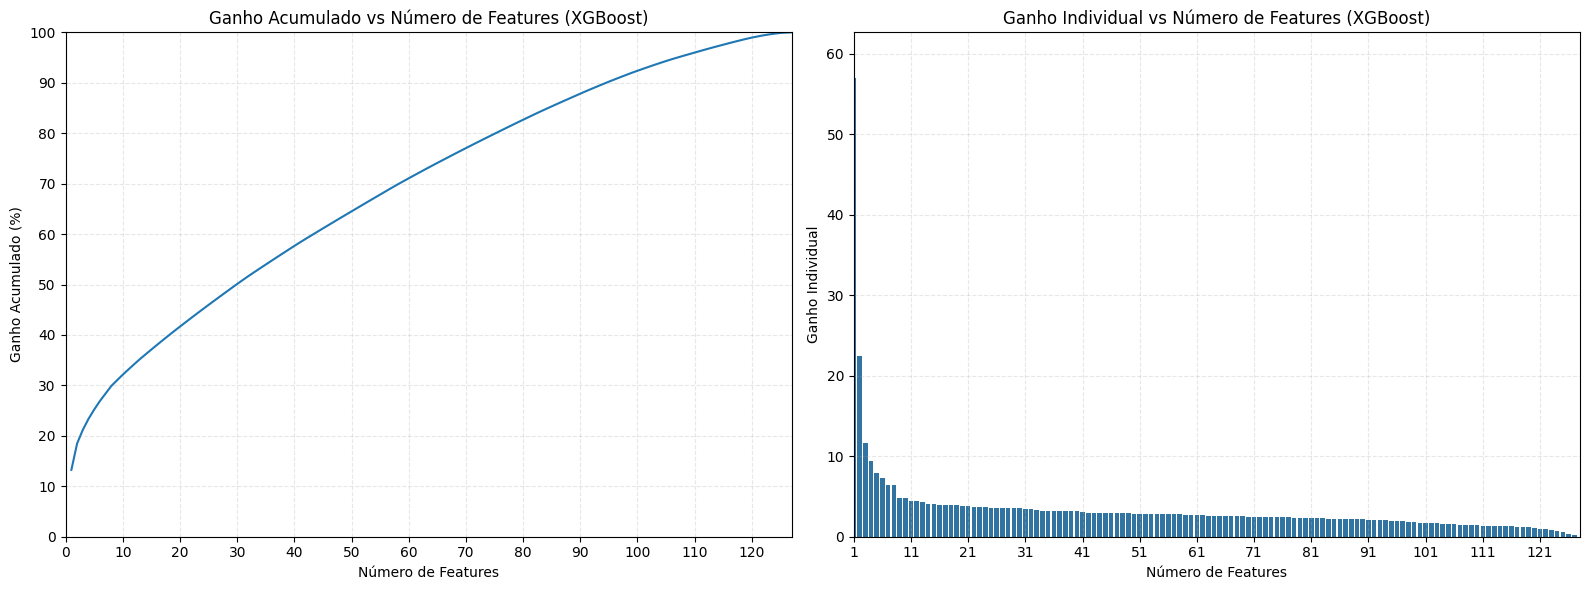

In [37]:
# Análise de Ganho Acumulado das Features
## Ganho Acumulado
importancias = importancias.sort_values(by='Ganho', ascending=False)
importancias['Ganho Acumulado'] = importancias['Ganho'].cumsum()
importancias['Ganho Acumulado (%)'] = (
    importancias['Ganho Acumulado'] / importancias['Ganho'].sum()
) * 100

## Criar coluna com número de features cumulativo
importancias['n_features'] = range(1, len(importancias) + 1)

# Plotagem
# Criar figura com dois subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Ganho Acumulado 
sns.lineplot(
    data=importancias, 
    x='n_features', 
    y='Ganho Acumulado (%)', 
    ax=axes[0]
)

axes[0].set_xlabel('Número de Features')
axes[0].set_ylabel('Ganho Acumulado (%)')
axes[0].set_title('Ganho Acumulado vs Número de Features (XGBoost)')
axes[0].set_xlim(0, importancias['n_features'].max())
axes[0].set_ylim(0, 100)
axes[0].set_xticks(range(0, importancias['n_features'].max() + 1, 10))
axes[0].set_yticks(range(0, 101, 10))
axes[0].grid(True, linestyle='--', alpha=0.3)

# Ganho Individual 
sns.barplot(
    data=importancias, 
    x='n_features', 
    y='Ganho',
    ax=axes[1]
)
axes[1].set_xlabel('Número de Features')
axes[1].set_ylabel('Ganho Individual')
axes[1].set_title('Ganho Individual vs Número de Features (XGBoost)')
axes[1].set_xlim(0, importancias['n_features'].max())
axes[1].set_ylim(0, importancias['Ganho'].max()*1.1)  
axes[1].set_xticks(range(0, importancias['n_features'].max() + 1, 10))
axes[1].grid(True, linestyle='--', alpha=0.3)

# Ajuste layout
plt.tight_layout()
plt.show()

In [38]:
score_modelos = {}

for num_features in range(10, 128, 10):
    # Seleção das top N features
    print('-' * 50)
    n_features = importancias[importancias['n_features'] <= num_features]
    sel_features = n_features.index.tolist()

    print(f"Número de features considerado: {num_features}")
    print(f"Features selecionadas: {sel_features}")

    # Pré-processamento
    pipe_prepropcessamento = Pipeline([
        ('standard_scaling', PadronizaDados(sel_features))
    ])

    # Pipeline completo
    pipeline_xgb_base = Pipeline([
        ('preprocessing', pipe_prepropcessamento),
        ('classifier', XGBClassifier(
                            eval_metric='aucpr',
                            objective='binary:logistic',
                            random_state=42
        ))
    ])

    # Validação cruzada
    scores = cross_validate(
        pipeline_xgb_base,
        X_treino[sel_features],
        y_treino,
        scoring=scoring,
        cv=5,
        n_jobs=-1
    )

    # Armazenar os scores
    score_modelos[f'XGBoost_{num_features}_features'] = scores

    # Resultados
    print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
    print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
    print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
    print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")


--------------------------------------------------
Número de features considerado: 10
Features selecionadas: ['ind_var26_cte', 'saldo_var30', 'var15', 'ind_var41_0', 'ind_var30', 'imp_op_var40_efect_ult3', 'num_var42_0', 'num_var26_0', 'imp_op_var41_efect_ult3', 'ind_var37_0']
ROC_AUC médio: 0.8066
Desvio ROC_AUC: 0.0062
PR_AUC médio : 0.1376
Desvio PR_AUC: 0.0059
--------------------------------------------------
Número de features considerado: 20
Features selecionadas: ['ind_var26_cte', 'saldo_var30', 'var15', 'ind_var41_0', 'ind_var30', 'imp_op_var40_efect_ult3', 'num_var42_0', 'num_var26_0', 'imp_op_var41_efect_ult3', 'ind_var37_0', 'num_var22_ult1', 'ind_var13', 'ind_var43_emit_ult1', 'num_var42', 'ind_var26_0', 'saldo_medio_var13_corto_ult3', 'imp_op_var41_efect_ult1', 'saldo_medio_var5_hace3', 'imp_op_var41_ult1', 'saldo_medio_var5_hace2']
ROC_AUC médio: 0.8077
Desvio ROC_AUC: 0.0039
PR_AUC médio : 0.1513
Desvio PR_AUC: 0.0099
--------------------------------------------------
N

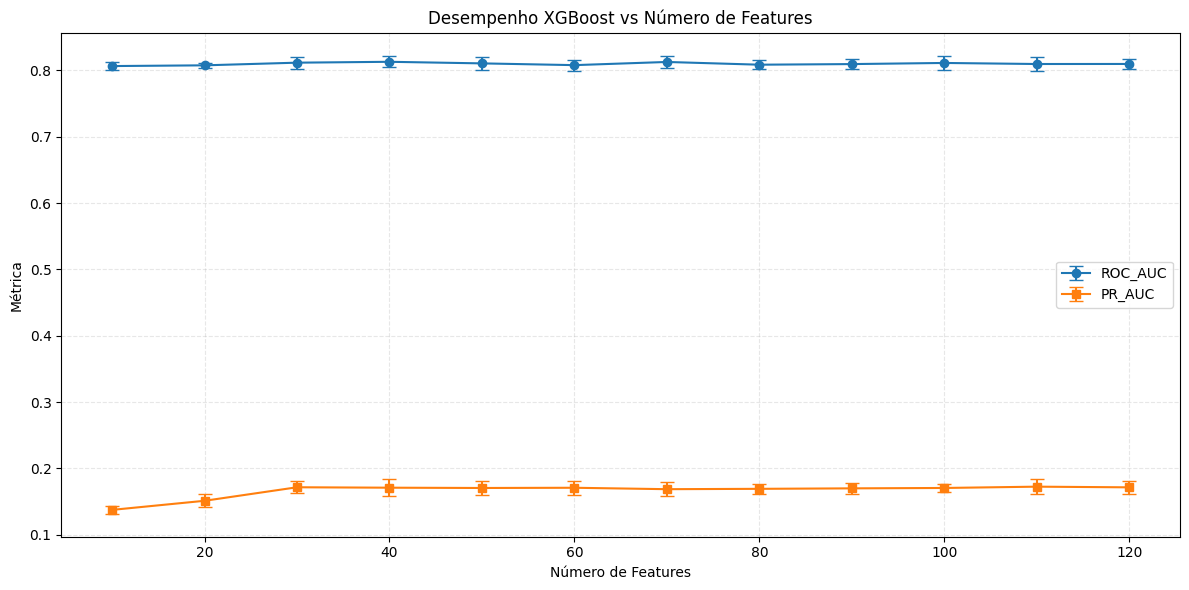

In [39]:
# Preparar os dados para o gráfico
resultados = []

for key, scores in score_modelos.items():
    n_features = int(key.split('_')[1])  # extrai o número de features da chave
    resultados.append({
        'n_features': n_features,
        'roc_auc_mean': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std(),
        'pr_auc_mean': scores['test_pr_auc'].mean(),
        'pr_auc_std': scores['test_pr_auc'].std()
    })

df_resultados = pd.DataFrame(resultados).sort_values('n_features')

# Plot
plt.figure(figsize=(12, 6))

# ROC_AUC
plt.errorbar(
    df_resultados['n_features'], 
    df_resultados['roc_auc_mean'], 
    yerr=df_resultados['roc_auc_std'], 
    label='ROC_AUC', 
    marker='o', 
    capsize=5
)

# PR_AUC
plt.errorbar(
    df_resultados['n_features'], 
    df_resultados['pr_auc_mean'], 
    yerr=df_resultados['pr_auc_std'], 
    label='PR_AUC', 
    marker='s', 
    capsize=5
)

plt.xlabel('Número de Features')
plt.ylabel('Métrica')
plt.title('Desempenho XGBoost vs Número de Features')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [40]:
df_resultados

,n_features,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,10,0.806585,0.006223,0.137562,0.005935
1,20,0.807686,0.003901,0.151271,0.009907
2,30,0.811699,0.009101,0.171654,0.009148
3,40,0.813023,0.008157,0.171007,0.012925
4,50,0.810630,0.010041,0.170570,0.010212
5,60,0.807988,0.008419,0.170901,0.010366
6,70,0.812765,0.009388,0.168756,0.010513
7,80,0.808647,0.007210,0.169295,0.007519
8,90,0.809573,0.008054,0.170004,0.008663
9,100,0.811271,0.010038,0.170596,0.006157


In [41]:
# Modelo com as top 10 features
print('-' * 50)
n = 10
n_features = importancias[importancias['n_features'] <= n]
sel_features = n_features.index.tolist()
X_t10 = X[sel_features]

print(f"Número de features considerado: {n}")
print(f"Features selecionadas: {sel_features}")

# Pré-processamento
pipe_prepropcessamento = Pipeline([
    ('standard_scaling', PadronizaDados(sel_features))
])

# Pipeline completo
pipeline_xgb_base = Pipeline([
    ('preprocessing', pipe_prepropcessamento),
    ('classifier', XGBClassifier(
                    eval_metric='aucpr',
                    objective='binary:logistic',
                    random_state=42
    ))
])

# Validação cruzada
scores = cross_validate(
    pipeline_xgb_base,
    X_treino[sel_features],
    y_treino,
    scoring=scoring,
    cv=5,
    n_jobs=-1
    )

# Resultados
print(f"ROC_AUC médio: {scores['test_roc_auc'].mean():.4f}")
print(f"Desvio ROC_AUC: {scores['test_roc_auc'].std():.4f}")
print(f"PR_AUC médio : {scores['test_pr_auc'].mean():.4f}")
print(f"Desvio PR_AUC: {scores['test_pr_auc'].std():.4f}")


--------------------------------------------------
Número de features considerado: 10
Features selecionadas: ['ind_var26_cte', 'saldo_var30', 'var15', 'ind_var41_0', 'ind_var30', 'imp_op_var40_efect_ult3', 'num_var42_0', 'num_var26_0', 'imp_op_var41_efect_ult3', 'ind_var37_0']
ROC_AUC médio: 0.8066
Desvio ROC_AUC: 0.0062
PR_AUC médio : 0.1376
Desvio PR_AUC: 0.0059


In [42]:
X_t10.head(5)

,ind_var26_cte,saldo_var30,var15,ind_var41_0,ind_var30,imp_op_var40_efect_ult3,num_var42_0,num_var26_0,imp_op_var41_efect_ult3,ind_var37_0
0,0,0.00,23,1,0,0.0,3,0,0.0,0
1,0,300.00,34,1,1,0.0,3,0,0.0,0
2,0,3.00,23,1,1,0.0,3,0,0.0,0
3,0,70.62,37,1,1,0.0,3,0,0.0,1
4,0,135003.00,39,1,1,0.0,6,0,0.0,0


In [43]:
for col in X_t10.columns:
    print(col, X_t10[col].nunique())

ind_var26_cte 2
saldo_var30 16940
var15 100
ind_var41_0 2
ind_var30 2
imp_op_var40_efect_ult3 29
num_var42_0 8
num_var26_0 9
imp_op_var41_efect_ult3 454
ind_var37_0 2


In [44]:
for col in X_t10.columns:
    if X_t10[col].nunique() <= 10:
        print(f"\n{col} (categórica):")
        print(X_t10[col].value_counts())


ind_var26_cte (categórica):
ind_var26_cte
0    73925
1     2095
Name: count, dtype: int64

ind_var41_0 (categórica):
ind_var41_0
1    66843
0     9177
Name: count, dtype: int64

ind_var30 (categórica):
ind_var30
1    55710
0    20310
Name: count, dtype: int64

num_var42_0 (categórica):
num_var42_0
3      70242
6       5126
0        436
9        203
12         9
15         2
18         1
114        1
Name: count, dtype: int64

num_var26_0 (categórica):
num_var26_0
0     74147
3      1574
6       240
9        42
12       12
15        2
33        1
21        1
27        1
Name: count, dtype: int64

ind_var37_0 (categórica):
ind_var37_0
0    71059
1     4961
Name: count, dtype: int64


In [45]:
# Colunas estranhas... Vamos analisar a porcentagen...
print(X_t10['num_var26_0'].value_counts(normalize=True) * 100)
print('')
print(X_t10['num_var42_0'].value_counts(normalize=True) * 100)

num_var26_0
0     97.536175
3      2.070508
6      0.315706
9      0.055249
12     0.015785
15     0.002631
33     0.001315
21     0.001315
27     0.001315
Name: proportion, dtype: float64

num_var42_0
3      92.399369
6       6.742962
0       0.573533
9       0.267035
12      0.011839
15      0.002631
18      0.001315
114     0.001315
Name: proportion, dtype: float64


- Nas duas colunas os valores são todos múltiplos de 3
- num_var26_0: valores > 0 são muitos raros
- num_var42_0: valores > 6 são muitos raros

Como essas categorias são raras, criar uma nova coluna para cada uma representando se é rara ou não pode auxilar o modelo

In [46]:
# COlunas a serem modificadas
colunas = ["num_var26_0", "num_var42_0"]

for col in colunas:
    # Marcação do Quartil
    X_t10.loc[:, col + '_quartil'] = pd.qcut(
        X_t10[col], q=4, labels=False, duplicates='drop'
    )

    # Marcação e valores raros
    freq = X_t10[col].value_counts(normalize=True)
    raras = freq[freq < 0.01].index
    X_t10.loc[:, col + '_rare'] = X_t10[col].isin(raras).astype(int)

C:\Users\mateu\AppData\Local\Temp\ipykernel_2700\2197995739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_t10.loc[:, col + '_quartil'] = pd.qcut(
C:\Users\mateu\AppData\Local\Temp\ipykernel_2700\2197995739.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_t10.loc[:, col + '_rare'] = X_t10[col].isin(raras).astype(int)
C:\Users\mateu\AppData\Local\Temp\ipykernel_2700\2197995739.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [47]:
X_t10.head(5)

,ind_var26_cte,saldo_var30,var15,ind_var41_0,ind_var30,imp_op_var40_efect_ult3,num_var42_0,num_var26_0,imp_op_var41_efect_ult3,ind_var37_0,num_var26_0_quartil,num_var26_0_rare,num_var42_0_quartil,num_var42_0_rare
0,0,0.00,23,1,0,0.0,3,0,0.0,0,0,0,0,0
1,0,300.00,34,1,1,0.0,3,0,0.0,0,0,0,0,0
2,0,3.00,23,1,1,0.0,3,0,0.0,0,0,0,0,0
3,0,70.62,37,1,1,0.0,3,0,0.0,1,0,0,0,0
4,0,135003.00,39,1,1,0.0,6,0,0.0,0,0,0,1,0


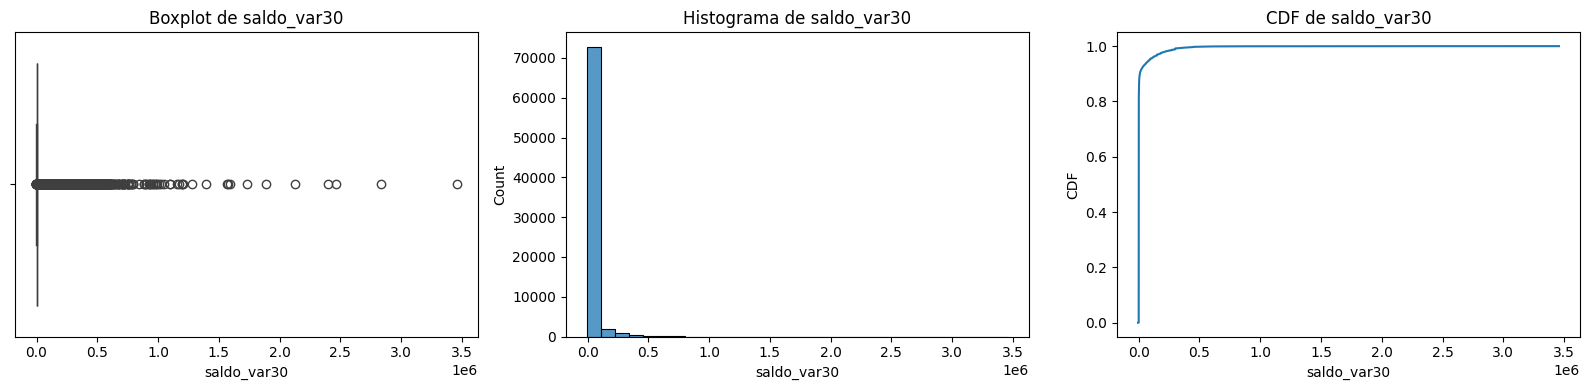

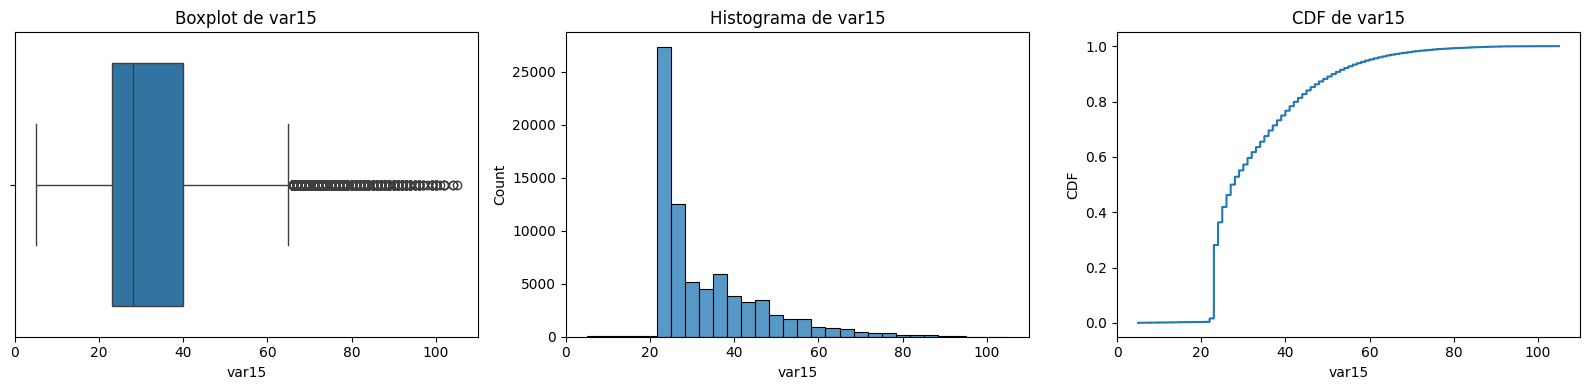

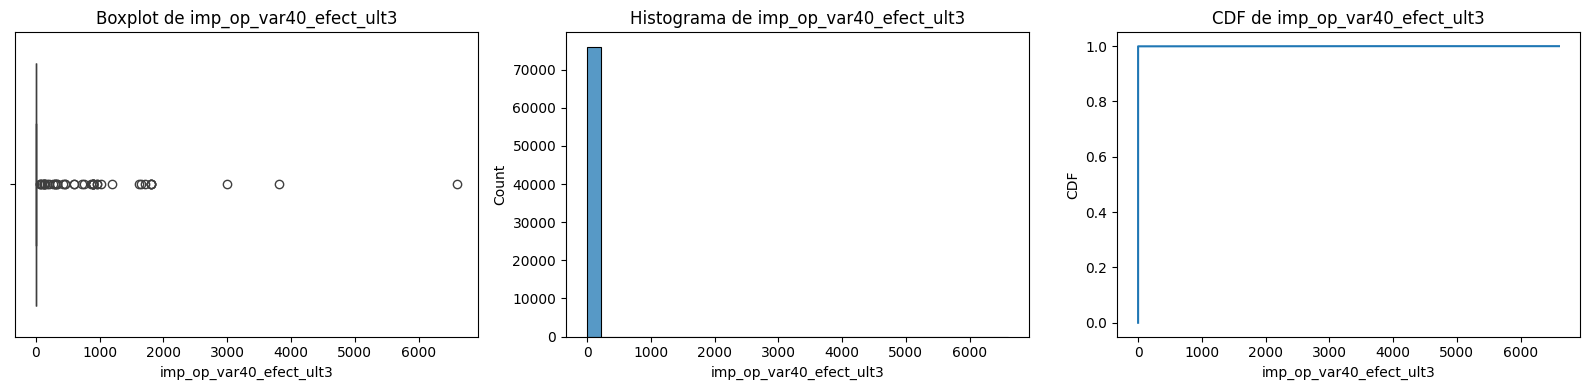

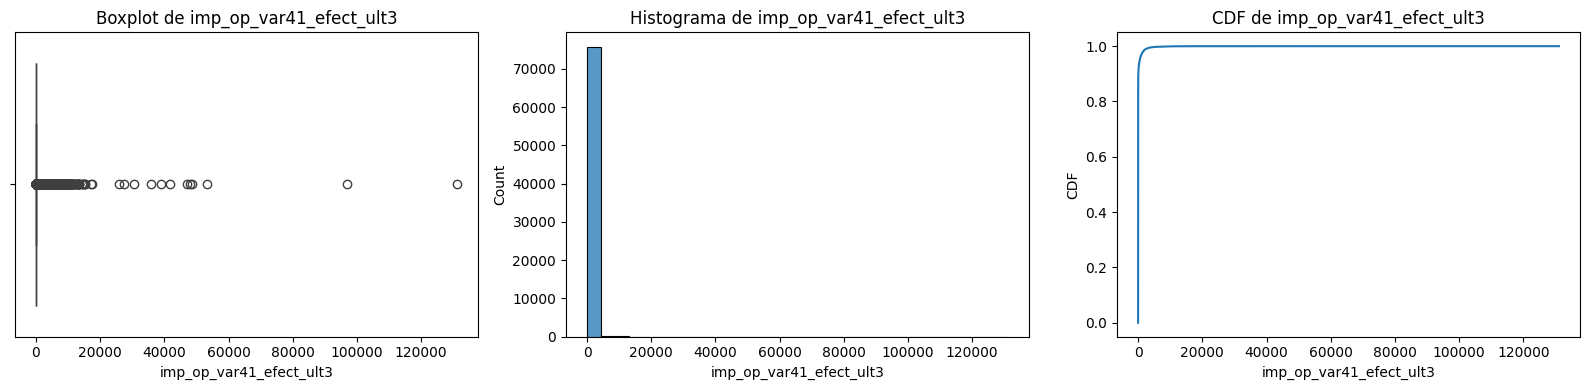

In [48]:
prob_cont = []
for col in X_t10.columns:
    if X_t10[col].nunique() > 10:
        prob_cont.append(col)

# Para cada coluna contínua
for col in prob_cont:
    plt.figure(figsize=(16,4))

  
    plt.subplot(1,3,1)
    sns.boxplot(x=X_t10[col])
    plt.title(f'Boxplot de {col}')

    plt.subplot(1,3,2)
    sns.histplot(X_t10[col], bins=30, kde=False)
    plt.title(f'Histograma de {col}')

    plt.subplot(1,3,3)
    sorted_vals = np.sort(X_t10[col])
    cdf = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)
    plt.plot(sorted_vals, cdf)
    plt.title(f'CDF de {col}')
    plt.xlabel(col)
    plt.ylabel('CDF')

    plt.tight_layout()
    plt.show()

In [49]:
# Investigação de saldo_var30
X_t10['saldo_var30'].describe()

count    7.602000e+04
mean     1.367967e+04
std      6.301408e+04
min     -4.942260e+03
25%      0.000000e+00
50%      3.000000e+00
75%      2.359950e+02
max      3.458077e+06
Name: saldo_var30, dtype: float64

In [50]:
# Top Menores 10
X_t10.nsmallest(10, 'saldo_var30')

,ind_var26_cte,saldo_var30,var15,ind_var41_0,ind_var30,imp_op_var40_efect_ult3,num_var42_0,num_var26_0,imp_op_var41_efect_ult3,ind_var37_0,num_var26_0_quartil,num_var26_0_rare,num_var42_0_quartil,num_var42_0_rare
17523,1,-4942.26,29,1,1,0.0,3,3,9720.0,0,0,0,0,0
8947,1,-2994.93,38,1,1,0.0,3,3,4200.0,1,0,0,0,0
41648,0,-2895.72,53,1,1,0.0,3,0,6090.0,1,0,0,0,0
22505,0,-1842.00,42,1,1,0.0,3,0,1440.0,0,0,0,0,0
3752,1,-1802.01,42,1,1,0.0,3,3,4680.0,1,0,0,0,0
19266,1,-1774.80,44,1,1,0.0,3,3,3150.0,1,0,0,0,0
14020,0,-1730.28,39,1,1,0.0,3,0,600.0,0,0,0,0,0
16536,0,-1496.64,42,1,1,0.0,3,0,690.0,0,0,0,0,0
9315,0,-928.65,31,1,1,0.0,3,0,0.0,0,0,0,0,0
53701,0,-852.69,36,1,1,0.0,3,0,0.0,1,0,0,0,0


In [51]:
X_t10['saldo_var30'].describe()

count    7.602000e+04
mean     1.367967e+04
std      6.301408e+04
min     -4.942260e+03
25%      0.000000e+00
50%      3.000000e+00
75%      2.359950e+02
max      3.458077e+06
Name: saldo_var30, dtype: float64

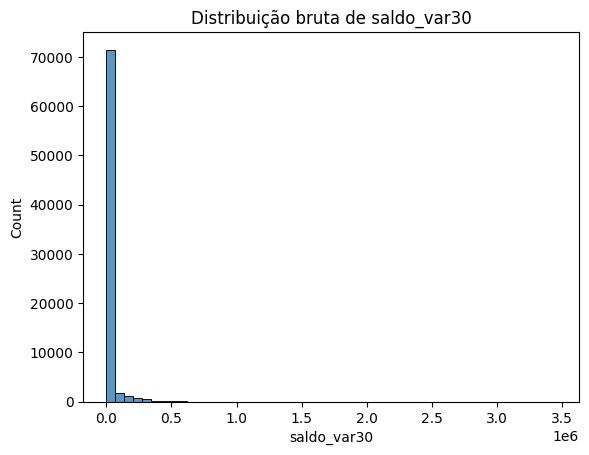

In [52]:
sns.histplot(X_t10['saldo_var30'], bins=50)
plt.title('Distribuição bruta de saldo_var30')
plt.show()

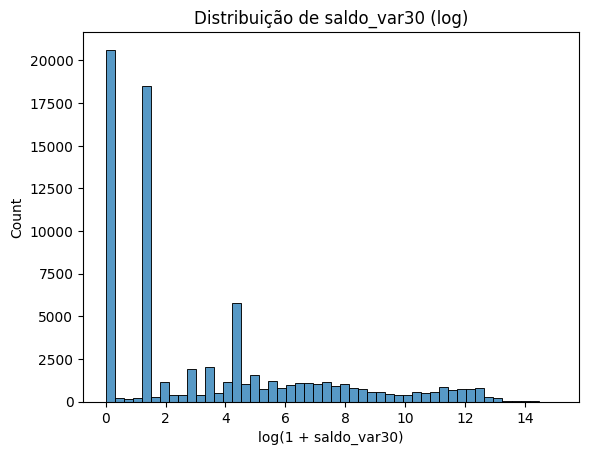

In [53]:
sns.histplot(np.log1p(X_t10['saldo_var30'].clip(lower=0)), bins=50)
plt.title('Distribuição de saldo_var30 (log)')
plt.xlabel('log(1 + saldo_var30)')
plt.show()


In [54]:
X_t10['saldo_var30'].quantile([0.10, 0.25, 0.5, 0.75, 0.90, 0.99, 0.999])

0.100         0.00000
0.250         0.00000
0.500         3.00000
0.750       235.99500
0.900      9213.22800
0.990    300011.44710
0.999    601559.18946
Name: saldo_var30, dtype: float64

In [55]:
n = len(X_t10)

((X_t10['saldo_var30'] > X_t10['saldo_var30'].quantile(0.99)).sum(),n)


(np.int64(761), 76020)

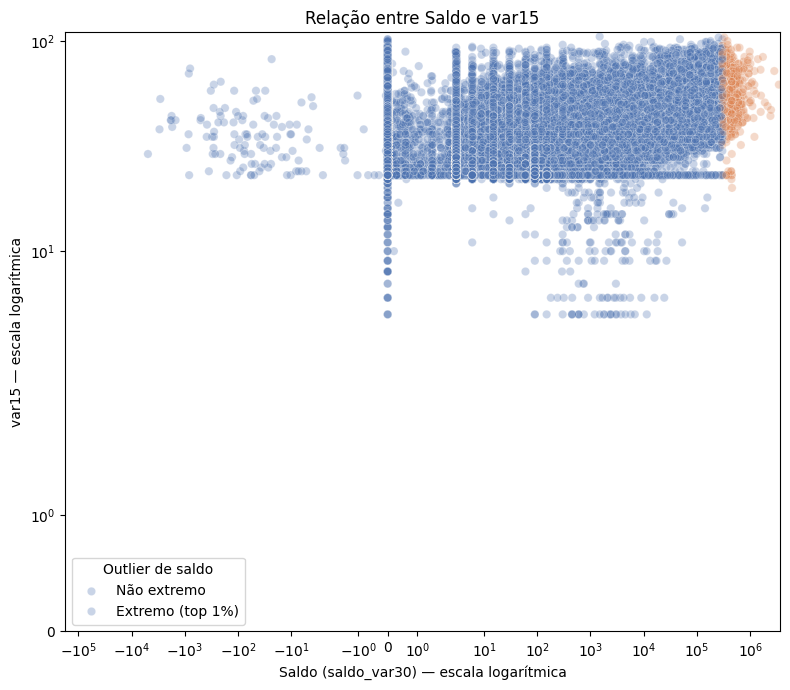

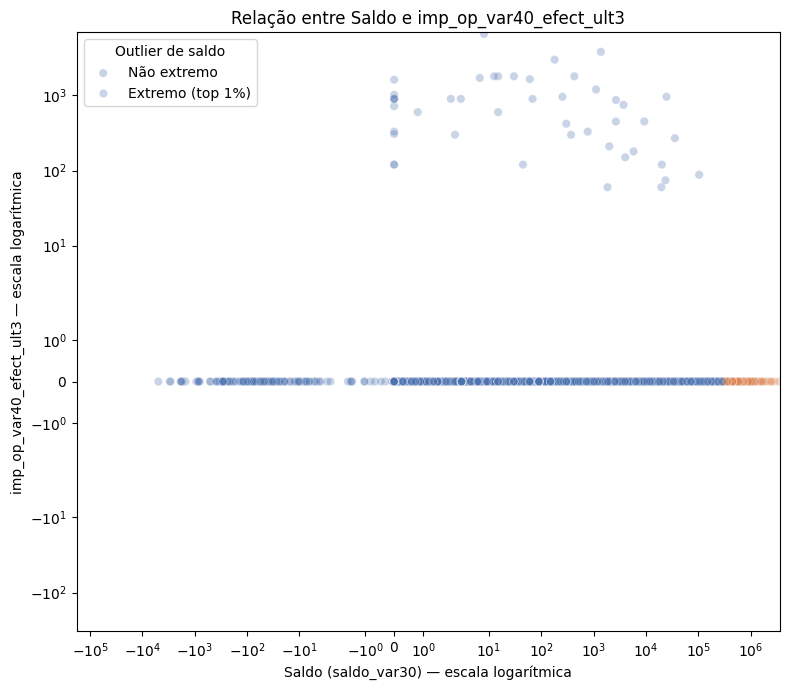

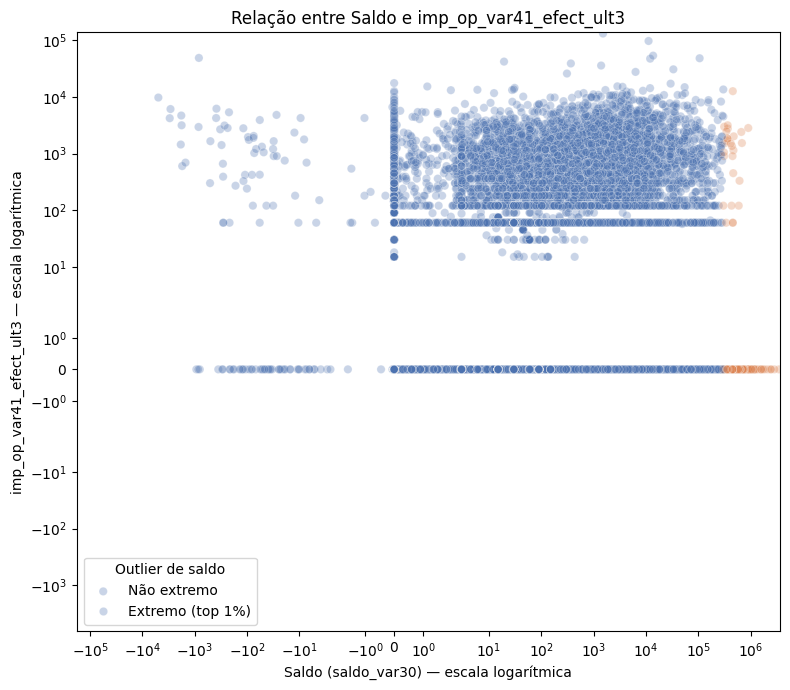

In [56]:
df = X_t10.copy()

df['outlier_saldo'] = (
    df['saldo_var30'] > df['saldo_var30'].quantile(0.99)
)

for var in prob_cont:
    if var == 'saldo_var30':
        continue

    plt.figure(figsize=(8, 7))

    sns.scatterplot(
        data=df,
        x='saldo_var30',
        y=var,
        hue='outlier_saldo',
        alpha=0.3,
        palette={False: '#4C72B0', True: '#DD8452'}
    )

    plt.xscale('symlog')
    plt.yscale('symlog')

    plt.xlabel('Saldo (saldo_var30) — escala logarítmica')
    plt.ylabel(f'{var} — escala logarítmica')

    plt.title(f'Relação entre Saldo e {var}')

    plt.legend(
        title='Outlier de saldo',
        labels=['Não extremo', 'Extremo (top 1%)']
    )

    plt.tight_layout()
    plt.show()


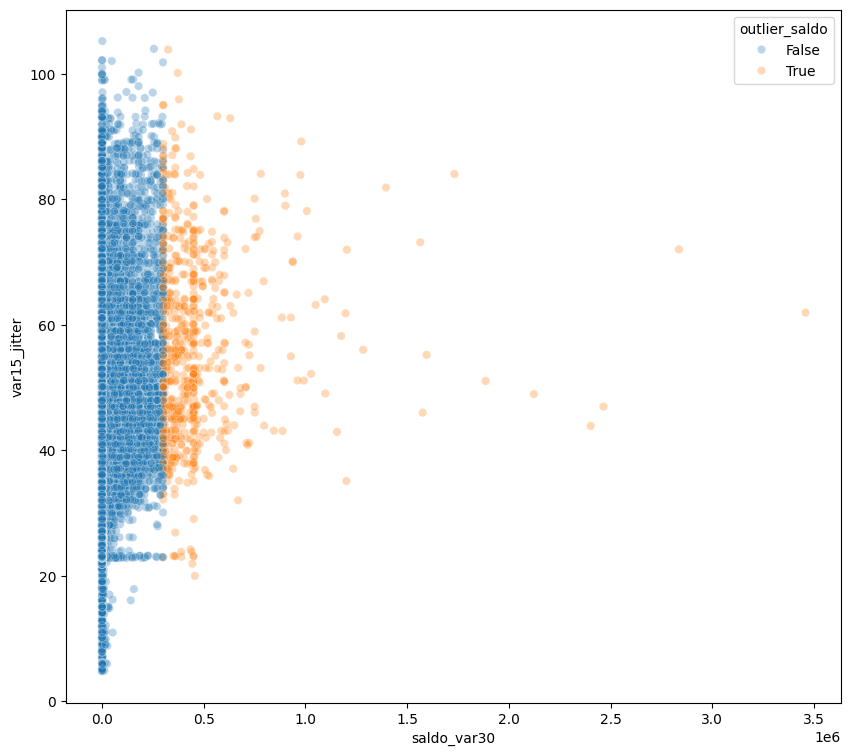

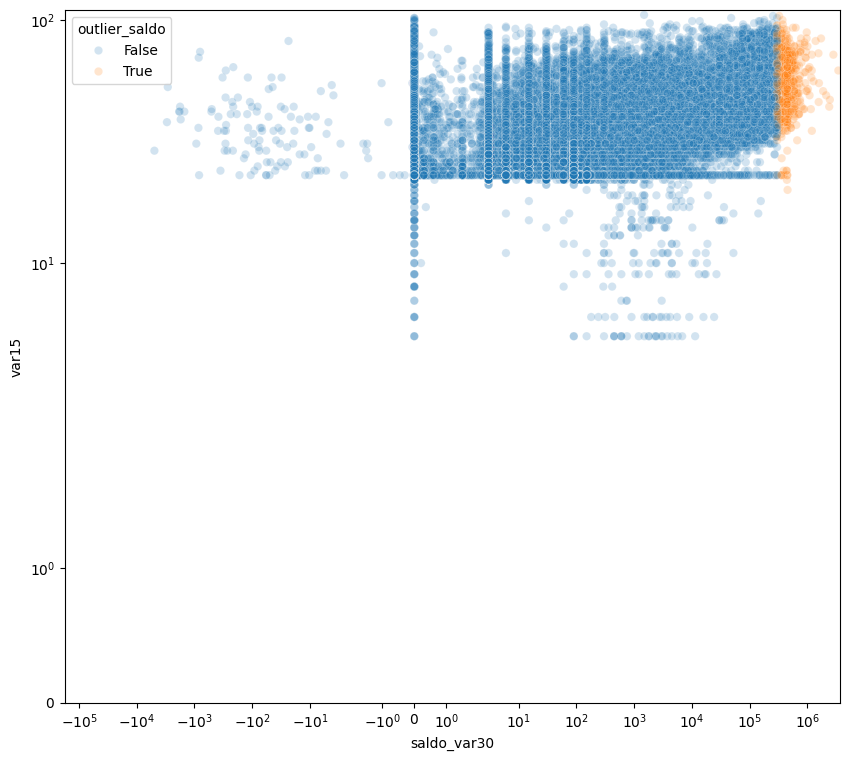

In [57]:
df_plot = df.copy()
df_plot['var15_jitter'] = df_plot['var15'] + np.random.uniform(-0.2, 0.2, size=len(df_plot))

plt.figure(figsize=(10,9))
sns.scatterplot(
    x='saldo_var30',
    y='var15_jitter',
    hue='outlier_saldo',
    data=df_plot,
    alpha=0.3
)

plt.figure(figsize=(10,9))
sns.scatterplot(
    x='saldo_var30',
    y='var15',
    hue='outlier_saldo',
    data=df,
    alpha=0.2
)
plt.xscale('symlog')
plt.yscale('symlog')
plt.show()


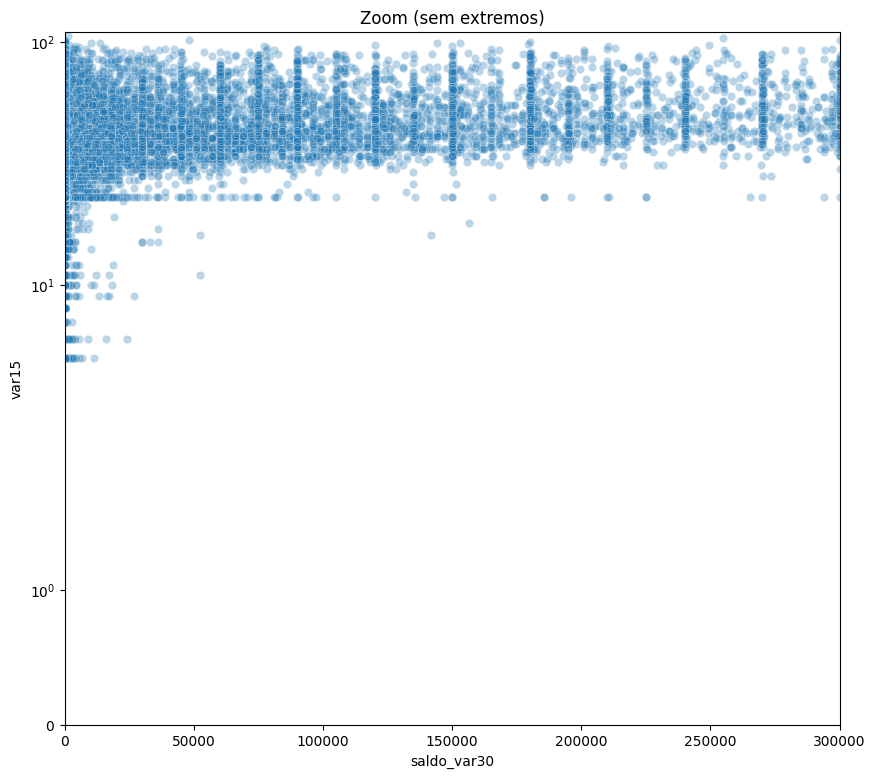

In [58]:
plt.figure(figsize=(10,9))
sns.scatterplot(
    x='saldo_var30',
    y='var15',
    data=df[df['outlier_saldo'] == False],
    alpha=0.3
)
plt.xlim(0, df['saldo_var30'].quantile(0.99))
plt.yscale('symlog')
plt.title('Zoom (sem extremos)')
plt.show()


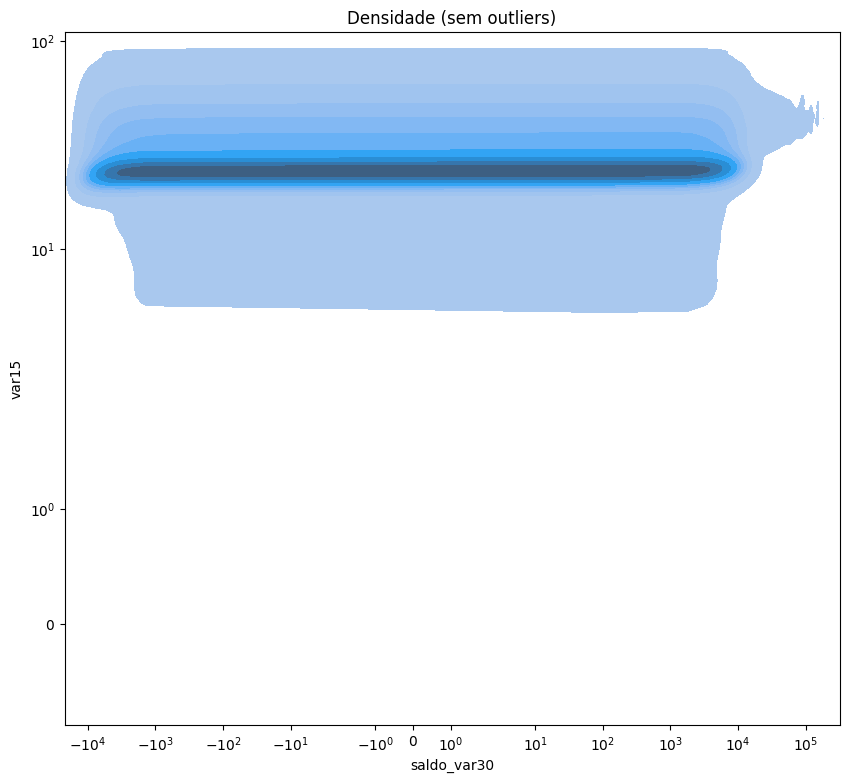

In [59]:
plt.figure(figsize=(10, 9))

sns.kdeplot(
    data=df[df['outlier_saldo'] == False],
    x='saldo_var30',
    y='var15',
    fill=True,
    thresh=0.05
)
plt.xscale('symlog')
plt.yscale('symlog')
plt.title('Densidade (sem outliers)')
plt.show()


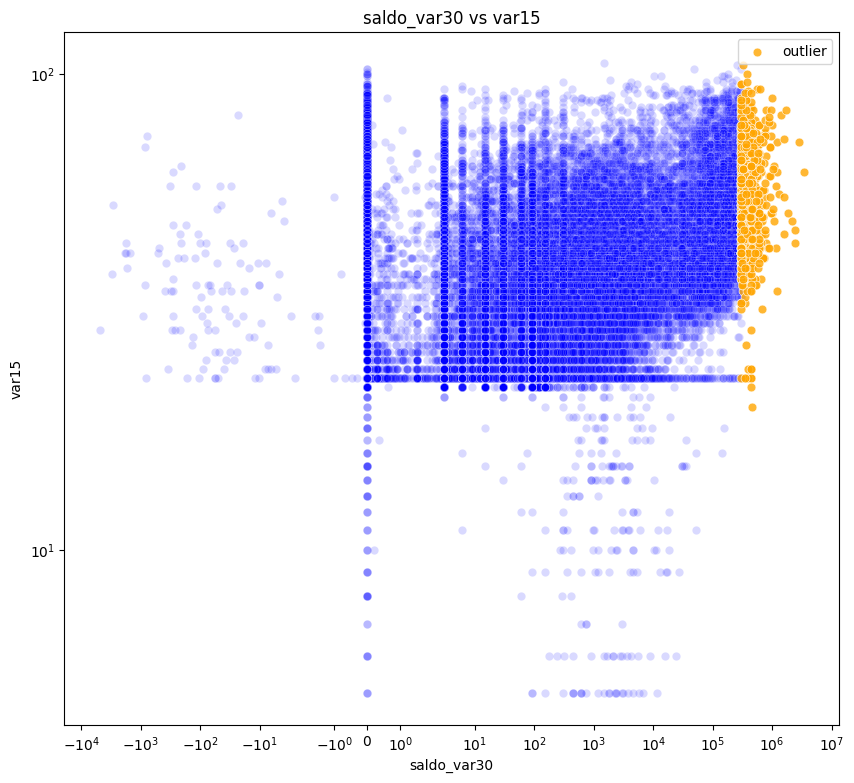

In [60]:
plt.figure(figsize=(10, 9))

# pontos normais (bem claros)
sns.scatterplot(
    x='saldo_var30',
    y='var15',
    data=df[df['outlier_saldo'] == False],
    alpha=0.15,
    color='blue'
)

# outliers (bem visíveis)
sns.scatterplot(
    x='saldo_var30',
    y='var15',
    data=df[df['outlier_saldo'] == True],
    alpha=0.8,
    color='orange',
    s=40,
    label='outlier'
)

plt.xscale('symlog')
plt.yscale('symlog')
plt.title('saldo_var30 vs var15')
plt.legend()
plt.show()


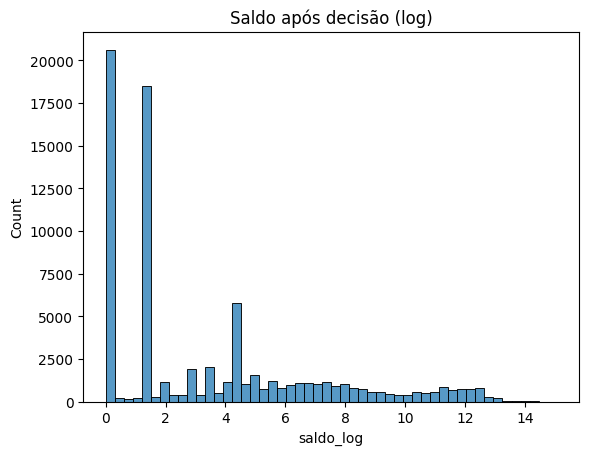

,count,mean,std,min,25%,50%,75%,max
saldo_extremo,,,,,,,,
False,75259.0,9267.344196,37081.280474,-4942.26,0.00,3.0,181.41,300009.09
True,761.0,450036.445033,261593.848791,300012.00,317761.83,389322.0,453372.63,3458077.32


In [63]:
sns.histplot(X_t10['saldo_log'], bins=50)
plt.title('Saldo após decisão (log)')
plt.show()

X_t10.groupby('saldo_extremo')['saldo_var30'].describe()
